# Anomaly Detection Challenge 3
## Miguel Sandim and Paula Fortuna

## 0 - Library Imports & Utils

In [1]:
# pandas
import pandas as pd
from pandas import Series,DataFrame

# numpy, matplotlib, seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Random libraries and seeds:
import random
random.seed(2)
np.random.seed(2)

pd.set_option('display.max_columns', None)

In [27]:
# From: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

######################################
# Function Save Data To CSV
######################################

def saveDataToCSV(Y_pred):
    id_list = range(1, len(Y_pred) + 1)
    submission = pd.DataFrame({
        "Id": id_list,
        "Label": Y_pred
    })
    submission = submission[['Id', 'Label']]
    submission.to_csv('submission.csv', index=False)
    return


# 1 - Data Reading

### 1.1 Load data

In [3]:
# read from csv
train_df = pd.read_csv("data/training-set.csv")
test_df = pd.read_csv("data/testing-set.csv")

In [4]:
train_df["label"].value_counts()

0    56000
1       41
Name: label, dtype: int64

In [5]:
41/(41 + 56000) * 100

0.07316072161453221

## About 0.07% of our dataset are anomalous cases.

# 2 - Data Pre-Processing

In [6]:
import sklearn.preprocessing as skpre

## 2.1 - Solve Missing Values

## 2.2 - Feature Extraction

### 2.2.1 - Features from paper

In [7]:
train_df.shape

(56041, 45)

## 2.4 Sampling

### 2.4.1 Undersampling

In [8]:
def undersampling(data):
    ids_to_sample = data[data["fake_review"] == "N"].index.values
    sample_size = data[data["fake_review"] == "Y"].shape[0]
    anomalies = data[data["fake_review"] == "Y"].index.values
    
    final_ids = np.append(np.random.choice(ids_to_sample, size = sample_size), anomalies)
    #print(ids_to_sample)
    #data[fake_review]
    return data.iloc[final_ids]
    
#train_df_joined = undersampling(train_df_joined)  

### 2.4.2 Oversampling

In [9]:
def oversampling(data):
    anomalies = data[data["fake_review"] == "Y"]
    data = data.append(anomalies)
    data = data.append(anomalies)
    data = data.append(anomalies)
    data = data.append(anomalies)
    data = data.append(anomalies)
    data = data.append(anomalies)
    return data

#train_df_joined = oversampling(train_df_joined)  

## 2.5 Define global variables for the model

In [10]:
def encodeVariables():
    
    target_variable = "label" # target variable
    
    dropVariableList = [
        
        ### All variables in this list will be deleted
        "id"
        ]
 
    # Drop variables in the X_train:
    X_train = train_df.drop(dropVariableList, axis=1)
    X_train.to_csv("X_train.csv", index = False, encoding='utf-8') # Save this in a CSV before dropping target
    
    # Drop target variables in the X_train:
    X_train = X_train.drop(target_variable, axis=1)
    X_train = X_train.drop("attack_cat", axis=1)
    
    # Drop variables in the X_test:
    X_test = test_df.drop(dropVariableList, axis=1)
    
    # Drop variables in the Y_train:
    Y_train = train_df[target_variable]

    # Transform categorical variables for X_train:
    categoricalVariableList = [
        "proto",
        "service",
        "state"
    ]
    
    for var_name in categoricalVariableList:
        encoder = skpre.LabelEncoder().fit(X_train[var_name].append(X_test[var_name]))
        X_train[var_name] = encoder.transform(X_train[var_name])
        X_test[var_name] = encoder.transform(X_test[var_name])

    # Transform categorical variables for Y_train
    Y_train = skpre.LabelEncoder().fit_transform(Y_train)

    print(X_train)
    #print(X_test)
    print(Y_train)
    
    return X_train, Y_train, X_test

#train_df_joined = train_df_joined.iloc[np.random.permutation(len(train_df_joined))]

X_train, Y_train, X_test = encodeVariables()

             dur  proto  service  state  spkts  dpkts  sbytes  dbytes  \
0       0.121478    113        0      4      6      4     258     172   
1       0.649902    113        0      4     14     38     734   42014   
2       1.623129    113        0      4      8     16     364   13186   
3       1.681642    113        3      4     12     12     628     770   
4       0.449454    113        0      4     10      6     534     268   
5       0.380537    113        0      4     10      6     534     268   
6       0.637109    113        0      4     10      8     534     354   
7       0.521584    113        0      4     10      8     534     354   
8       0.542905    113        0      4     10      8     534     354   
9       0.258687    113        0      4     10      6     534     268   
10      0.304853    113        0      4     12      6    4142     268   
11      2.093085    113        9      4     62     28   56329    2212   
12      0.416952    113        0      4     10     

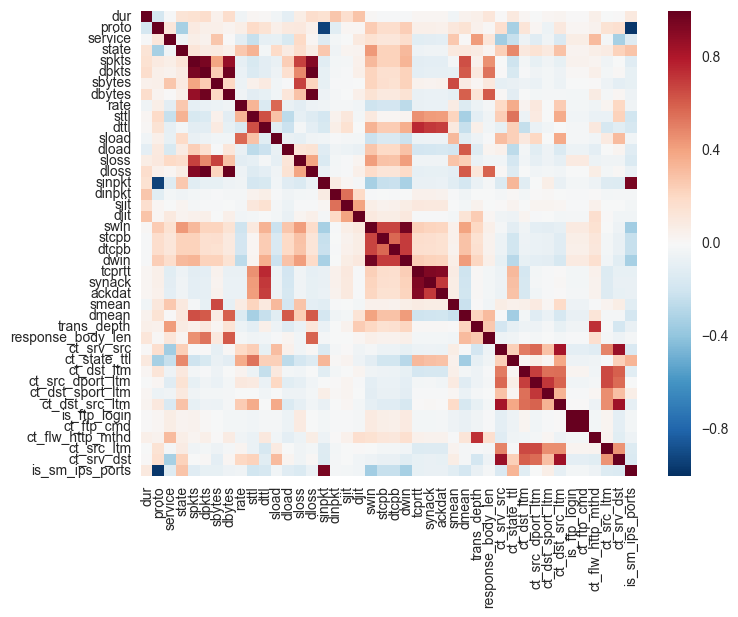

In [11]:
def plotCorrelations():
    plt.figure(figsize=(8, 6), dpi=500)
    corr = X_train.corr()
    sns.heatmap(corr, 
                xticklabels=corr.columns.values,
                yticklabels=corr.columns.values)
    
plotCorrelations()

In [12]:
X_train

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports
0,0.121478,113,0,4,6,4,258,172,74.087490,252,254,1.415894e+04,8495.365234,0,0,24.295600,8.375000,30.177547,11.830604,255,621772692,2202533631,255,0.000000,0.000000,0.000000,43,43,0,0,1,0,1,1,1,1,0,0,0,1,1,0
1,0.649902,113,0,4,14,38,734,42014,78.473372,62,252,8.395112e+03,503571.312500,2,17,49.915000,15.432865,61.426934,1387.778330,255,1417884146,3077387971,255,0.000000,0.000000,0.000000,52,1106,0,0,43,1,1,1,1,2,0,0,0,1,6,0
2,1.623129,113,0,4,8,16,364,13186,14.170161,62,252,1.572272e+03,60929.230470,1,6,231.875571,102.737203,17179.586860,11420.926230,255,2116150707,2963114973,255,0.111897,0.061458,0.050439,46,824,0,0,7,1,2,1,1,3,0,0,0,2,6,0
3,1.681642,113,3,4,12,12,628,770,13.677108,62,252,2.740179e+03,3358.622070,1,3,152.876547,90.235726,259.080172,4991.784669,255,1107119177,1047442890,255,0.000000,0.000000,0.000000,52,64,0,0,1,1,2,1,1,3,1,1,0,2,1,0
4,0.449454,113,0,4,10,6,534,268,33.373826,254,252,8.561499e+03,3987.059814,2,1,47.750333,75.659602,2415.837634,115.807000,255,2436137549,1977154190,255,0.128381,0.071147,0.057234,53,45,0,0,43,1,2,2,1,40,0,0,0,2,39,0
5,0.380537,113,0,4,10,6,534,268,39.417980,254,252,1.011203e+04,4709.134766,2,1,39.928778,52.241000,2223.730342,82.550500,255,3984155503,1796040391,255,0.172934,0.119331,0.053603,53,45,0,0,43,1,2,2,1,40,0,0,0,2,39,0
6,0.637109,113,0,4,10,8,534,354,26.683033,254,252,6.039783e+03,3892.583740,2,1,68.267778,81.137711,4286.828570,119.422719,255,1787309226,1767180493,255,0.143337,0.069136,0.074201,53,44,0,0,43,1,1,1,1,40,0,0,0,1,39,0
7,0.521584,113,0,4,10,8,534,354,32.593026,254,252,7.377527e+03,4754.747070,2,1,55.794000,66.054141,3770.580726,118.962633,255,205985702,316006300,255,0.116615,0.059195,0.057420,53,44,0,0,43,1,3,3,1,40,0,0,0,3,39,0
8,0.542905,113,0,4,10,8,534,354,31.313031,254,252,7.087796e+03,4568.018555,2,1,60.210889,68.109000,4060.625597,106.611547,255,884094874,3410317203,255,0.118584,0.066133,0.052451,53,44,0,0,43,1,3,3,1,40,0,0,0,3,39,0
9,0.258687,113,0,4,10,6,534,268,57.985135,254,252,1.487512e+04,6927.291016,2,1,27.505111,39.106801,1413.686415,57.200395,255,3368447996,584859215,255,0.087934,0.063116,0.024818,53,45,0,0,43,1,3,3,1,40,0,0,0,3,39,0


In [13]:
X_train.columns

Index(['dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss',
       'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin',
       'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm',
       'ct_srv_dst', 'is_sm_ips_ports'],
      dtype='object')

In [14]:
len(X_train.columns)

42

In [15]:
sum(Y_train)

41

In [16]:
len(Y_train)

56041

### Normalize features

In [17]:
def featureNormalization():
    global X_train
    global X_test
    
    scaler = skpre.StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
#featureNormalization()

In [18]:
X_train

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports
0,0.121478,113,0,4,6,4,258,172,74.087490,252,254,1.415894e+04,8495.365234,0,0,24.295600,8.375000,30.177547,11.830604,255,621772692,2202533631,255,0.000000,0.000000,0.000000,43,43,0,0,1,0,1,1,1,1,0,0,0,1,1,0
1,0.649902,113,0,4,14,38,734,42014,78.473372,62,252,8.395112e+03,503571.312500,2,17,49.915000,15.432865,61.426934,1387.778330,255,1417884146,3077387971,255,0.000000,0.000000,0.000000,52,1106,0,0,43,1,1,1,1,2,0,0,0,1,6,0
2,1.623129,113,0,4,8,16,364,13186,14.170161,62,252,1.572272e+03,60929.230470,1,6,231.875571,102.737203,17179.586860,11420.926230,255,2116150707,2963114973,255,0.111897,0.061458,0.050439,46,824,0,0,7,1,2,1,1,3,0,0,0,2,6,0
3,1.681642,113,3,4,12,12,628,770,13.677108,62,252,2.740179e+03,3358.622070,1,3,152.876547,90.235726,259.080172,4991.784669,255,1107119177,1047442890,255,0.000000,0.000000,0.000000,52,64,0,0,1,1,2,1,1,3,1,1,0,2,1,0
4,0.449454,113,0,4,10,6,534,268,33.373826,254,252,8.561499e+03,3987.059814,2,1,47.750333,75.659602,2415.837634,115.807000,255,2436137549,1977154190,255,0.128381,0.071147,0.057234,53,45,0,0,43,1,2,2,1,40,0,0,0,2,39,0
5,0.380537,113,0,4,10,6,534,268,39.417980,254,252,1.011203e+04,4709.134766,2,1,39.928778,52.241000,2223.730342,82.550500,255,3984155503,1796040391,255,0.172934,0.119331,0.053603,53,45,0,0,43,1,2,2,1,40,0,0,0,2,39,0
6,0.637109,113,0,4,10,8,534,354,26.683033,254,252,6.039783e+03,3892.583740,2,1,68.267778,81.137711,4286.828570,119.422719,255,1787309226,1767180493,255,0.143337,0.069136,0.074201,53,44,0,0,43,1,1,1,1,40,0,0,0,1,39,0
7,0.521584,113,0,4,10,8,534,354,32.593026,254,252,7.377527e+03,4754.747070,2,1,55.794000,66.054141,3770.580726,118.962633,255,205985702,316006300,255,0.116615,0.059195,0.057420,53,44,0,0,43,1,3,3,1,40,0,0,0,3,39,0
8,0.542905,113,0,4,10,8,534,354,31.313031,254,252,7.087796e+03,4568.018555,2,1,60.210889,68.109000,4060.625597,106.611547,255,884094874,3410317203,255,0.118584,0.066133,0.052451,53,44,0,0,43,1,3,3,1,40,0,0,0,3,39,0
9,0.258687,113,0,4,10,6,534,268,57.985135,254,252,1.487512e+04,6927.291016,2,1,27.505111,39.106801,1413.686415,57.200395,255,3368447996,584859215,255,0.087934,0.063116,0.024818,53,45,0,0,43,1,3,3,1,40,0,0,0,3,39,0


## 3.1 - Model selection based on which models do best in CV using default settings:

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier().fit(X_train, Y_train)

In [ ]:
rf.feature_importances_

In [ ]:
fe_v = [ 0.02744583,  0.15915509,  0.08051205,  0.04447052,  0.04513294,
        0.04927782,  0.02358031,  0.03260846,  0.04214492,  0.03326136,
        0.02448847,  0.02473819,  0.01179376,  0.04341354,  0.0080685 ,
        0.01392277,  0.00560562,  0.04049034,  0.02264503,  0.00721319,
        0.01633885,  0.01084221,  0.00328429,  0.03949145,  0.03993958,
        0.0446234 ,  0.0149503 ,  0.02259267,  0.02316186,  0.04480668]

fe_n = ['dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss',
       'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin',
       'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm',
       'ct_srv_dst', 'is_sm_ips_ports']

features = []
for i in range(0, len(fe_v)):
    features.append((fe_v[i], fe_n[i]))
    
features.sort(key = lambda x: x[0], reverse = True)
features

LR: 0.819797 (0.075372)


C:\Users\migsa\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\migsa\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\migsa\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\migsa\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\migsa\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\migsa\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\migsa\Anacond

LDA: 0.874375 (0.143783)
KNN: 0.571084 (0.098880)
CART: 0.634835 (0.068205)
NB: 0.805839 (0.094615)
NN: 0.542063 (0.060926)
RF: 0.826402 (0.101549)
AB: 0.948076 (0.032193)
XGB: 0.989410 (0.010540)


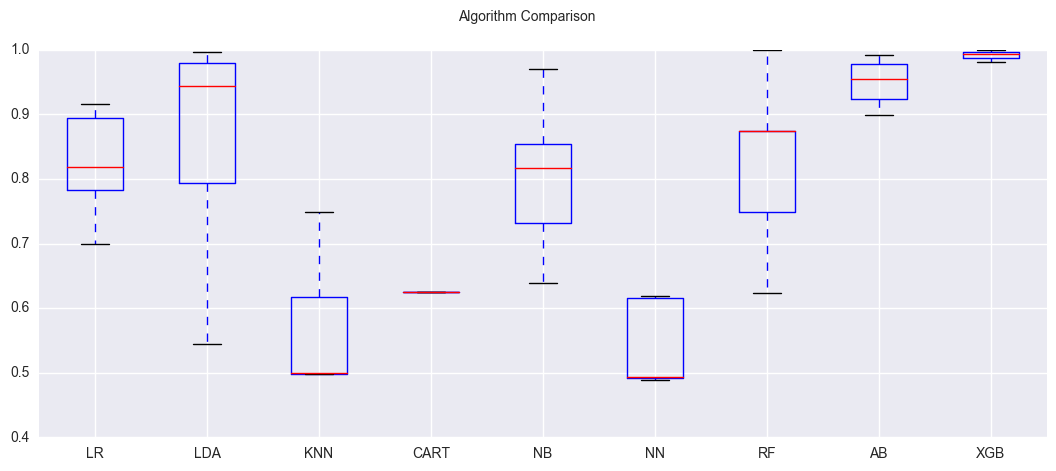

In [31]:
#inspired in http://machinelearningmastery.com/compare-machine-learning-algorithms-python-scikit-learn/

import sklearn.model_selection as mds
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import xgboost as xgb

def modelSelection():

    # prepare data

    #Y_train = train_df[:,-1]
    #X_train = train_df[:,:-1]

    #Y_train = train_df[len(train_df.columns)-1]
    #X_train = train_df.drop(len(train_df.columns)-1,axis=1)

    # prepare configuration for cross validation test harness
    num_folds = 10
    num_instances = len(X_train)

    # prepare models
    models = []
    models.append(('LR', LogisticRegression(random_state = 2)))
    models.append(('LDA', LinearDiscriminantAnalysis()))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('CART', DecisionTreeClassifier(random_state = 2)))
    models.append(('NB', GaussianNB()))
    #models.append(('SVM-Linear', SVC(kernel="linear")))
    #models.append(('SVM-Poly', SVC(kernel="poly")))
    #models.append(('SVM-RBF', SVC(kernel="rbf", random_state = 2)))
    models.append(('NN', MLPClassifier(random_state = 2))) 
    models.append(('RF', RandomForestClassifier(random_state = 2)))
    models.append(('AB', AdaBoostClassifier(random_state = 2)))
    models.append(('XGB', xgb.XGBClassifier()))

    # evaluate each model in turn
    results = []
    scoring = 'roc_auc' # try with 'roc_auc', f1'

    kfold = mds.StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=2)

    for model_name, model in models:
        cv_results = mds.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
        results.append({"name": model_name, "cv_results": cv_results, "mean": cv_results.mean(), "std": cv_results.std()})
        print("%s: %f (%f)" % (model_name, cv_results.mean(), cv_results.std()))

    # boxplot algorithm comparison
    fig = plt.figure(figsize=(13, 5), dpi=500)
    fig.suptitle('Algorithm Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot([x["cv_results"] for x in results])
    ax.set_xticklabels([x["name"] for x in results])
    plt.show()

    # order the models by the mean auc
    #results_by_strategy.sort(key=lambda x: x["mean"], reverse=True)
    #print([(x["name"], x["mean"]) for x in results])

modelSelection()

### Tuning Random Forests

In [ ]:
from sklearn.model_selection import GridSearchCV

def tuneRandomForests():
    
    grid = {
        "n_estimators": np.arange(10, 700, 20),
        "criterion": ["gini", "entropy"],
        "max_features": ["auto", "sqrt", "log2", None]
    }
    
    gsearch = GridSearchCV(estimator = RandomForestClassifier(), 
                            param_grid = grid, scoring='roc_auc', cv=10, n_jobs=5)
    
    result = gsearch.fit(X_train, Y_train)
    return result

tunningrf = tuneRandomForests()

In [ ]:
tunningrf.cv_results_

In [ ]:
tunningrf.best_params_

In [ ]:
tunningrf.best_score_

# 4 - Submission to Kaggle

In [28]:
# choose algorithm
def makeSubmissionKaggle(algorithm):
    algorithm.fit(X_train, Y_train)
    Y_pred = algorithm.predict(X_test)
    Y_pred = Y_pred.astype(int)

    # save data to CSV
    saveDataToCSV(Y_pred)
    
#makeSubmissionKaggle("07-spec-mean", xgb.XGBClassifier( learning_rate=0.01, n_estimators=5000, max_depth=7,
#                      min_child_weight=1, gamma=0, subsample=0.55, colsample_bytree=0.85,
#                      reg_alpha=1e-5, objective= 'binary:logistic', scale_pos_weight=1, seed=2))

#makeSubmissionKaggle("09-spec-min", LinearDiscriminantAnalysis(n_components = 1, shrinkage = "auto", solver="lsqr"))
#makeSubmissionKaggle(RandomForestClassifier(criterion = 'entropy', max_features = 'log2', n_estimators = 630))
#makeSubmissionKaggle(RandomForestClassifier(criterion = 'entropy', max_features = 'log2', n_estimators = 310))
makeSubmissionKaggle(xgb.XGBClassifier())